1. **Temporal cross-validation setup** 
   - Rolling window validation
2. **Model fine-tuning using time series-aware grid search**
3. **Extraction and storage of feature importance for each fold**
4. **Analysis of most frequently selected hyperparameters and features**
5. **Retraining with the dominant configuration**
6. **Final performance evaluation**

In [4]:
target = 'marketing_cost'

# this list was provided by Adam (current features in the causal model)
columns_used_to_train = [
'aov_eur',
'available_stock_value_after_discount_complete_eur',
'avg_temp',
'cpc',
'cr_tracked_%',
'email_recipients',
'email_visits',
'internalWeeks_until_SeasonalSaleStart',
'internal_Week_of_FW_Season',
'internal_Week_of_SS_Season',
'is_Peak_Driving_Public_Holiday_week',
'is_Sun_to_Mon_Shift_week',
'is_black_week_event',
'is_email_campaign_type_deal',
'is_email_campaign_type_liveshop',
'is_email_campaign_type_newsletter',
'is_percentage_on_top',
'is_percentage_on_top_applicable',
'is_season_sale_event',
'is_temp_drop_flag',
'number_days_after_last_event',
'number_days_till_next_event',
'number_orders',
'number_visits',
'sku_with_discount_%',
'stock_discount_rate_total_%',
'target_cpr']

In [7]:
import pandas as pd
import numpy as np
# from sklearn.ensemble import RandomForestRegressor
import xgboost as xg
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    explained_variance_score
)

# --- 1. Load & prep --------------------------------------------------------
df = pd.read_csv("Marketing_Cost_Data_for_taining_14072025.csv", parse_dates=['Unnamed: 0'])
df = df.rename(columns={'Unnamed: 0': 'date'})
df = df.sort_values('date').set_index('date')

X = df[columns_used_to_train].values
y = df[target].values
dates = df.index

In [ ]:
# --- 2. Carve off final hold-out (last 8 weeks) ----------------------------
H = 8    # hold-out horizon
train_cut = len(df) - H
X_hist, y_hist = X[:train_cut], y[:train_cut]
dates_hist = dates[:train_cut]

X_final, y_final = X[train_cut:], y[train_cut:]
dates_final = dates[train_cut:]

# --- 3. Rolling-origin CV on history ----------------------------------------
W = 52   # training window
h = 8    # test window
scores = []
best_params_list = []
feature_importances_list = []

# we can only start a fold where (start + W + h) ≤ len(history)
n_folds = (len(X_hist) - W - h) + 1

param_grid = {
    'min_child_weight': [0.3, 0.4, 0.5],
    'n_estimators':       [100, 200, 300],
    'learning_rate':      [0.01, 0.05, 0.1],    # if using XGBoost; RF ignores this
    'max_depth':          [5, 7, 9],
}

for i in tqdm(range(n_folds)):
    train_start = i
    train_end   = i + W          # exclusive
    test_end    = train_end + h  # exclusive

    X_tr = X_hist[train_start:train_end]
    y_tr = y_hist[train_start:train_end]
    X_va = X_hist[train_end:test_end]
    y_va = y_hist[train_end:test_end]

    # train
    current_model = xg.XGBRegressor(random_state=42, seed=123, n_jobs=-1)
    # Grid search
    grid_search = GridSearchCV(current_model, param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid_search.fit(X_tr, y_tr)
    # Get best model
    best_model = grid_search.best_estimator_
    # Get best parameters
    best_params = grid_search.best_params_
    # Fit best model
    best_model.fit(X_tr, y_tr)
    # Get feature importances
    feature_importances = best_model.feature_importances_
    importances = pd.Series(
        best_model.feature_importances_,
        index=columns_used_to_train
    )
    feature_importances_list.append(importances)
    # Get best parameters
    best_params_list.append(best_params)
    

    # predict & score
    y_pred = best_model.predict(X_va)
    mae = mean_absolute_error(y_va, y_pred)
    mse = mean_squared_error(y_va, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_va, y_pred)
    r2 = r2_score(y_va, y_pred)

    scores.append({'fold': i+1, 'mse': mse, 'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2})

    print(f"Fold {i+1:02d}: Train weeks {train_start+1}-{train_end}, "
          f"Test weeks {train_end+1}-{test_end} → MSE {mse:.2f}, MAE {mae:.2f}")

cv_df = pd.DataFrame(scores)
print("\nCV mean MSE:", cv_df['mse'].mean(), "MAE:", cv_df['mae'].mean())
feat_importance_df = pd.DataFrame(feature_importances_list)
best_params_df = pd.DataFrame(best_params_list)

In [48]:
cv_df['mape'].mean()

np.float64(0.0756754206238251)

In [76]:
# saving the files
cv_df.to_csv('./marketing_cost/files/cross_validation_results.csv')
feat_importance_df.to_csv('./marketing_cost/files/feature_importance_results.csv')
best_params_df.to_csv('./marketing_cost/files/best_params_results.csv')

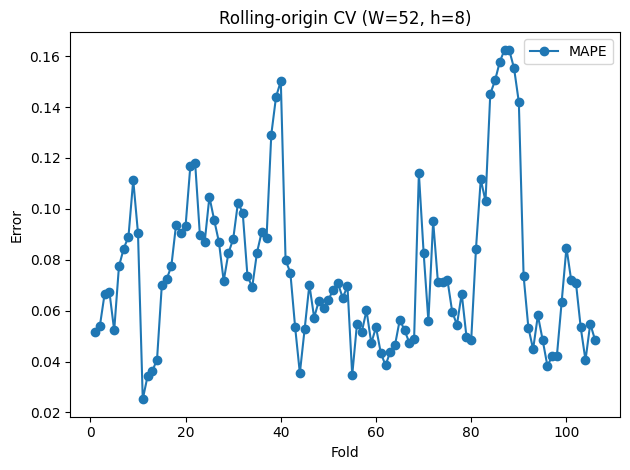

In [49]:
# --- 4. Plot CV metrics ----------------------------------------------------
plt.figure()
plt.plot(cv_df['fold'], cv_df['mape'], marker='o', label='MAPE')
# plt.plot(cv_df['fold'], cv_df['mae'], marker='s', label='MAE')
plt.xlabel("Fold")
plt.ylabel("Error")
plt.title(f"Rolling-origin CV (W={W}, h={H})")
plt.legend()
plt.tight_layout()
plt.show()

<Axes: >

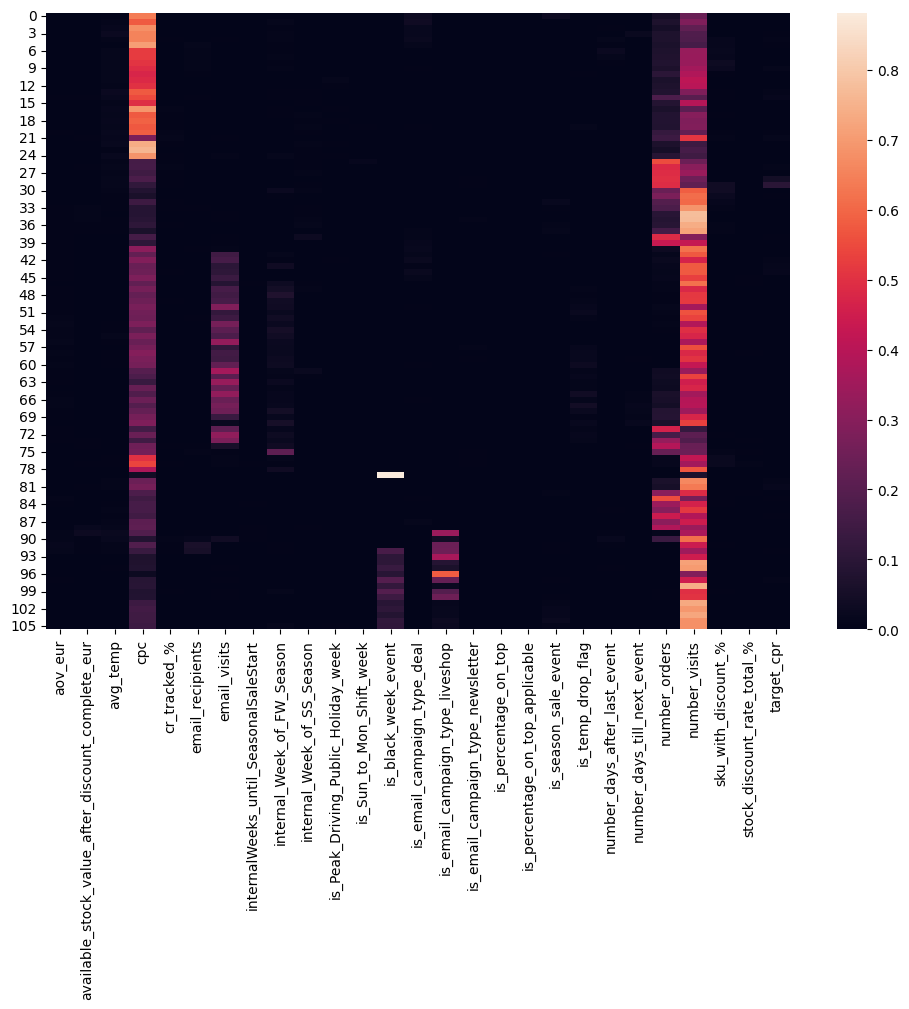

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
sns.heatmap(feat_importance_df)

## Base on Feature Importance Filtering Features to Use

In [41]:
feat_imp_mean_series = feat_importance_df.mean() * 100
feat_imp_mean_series.sort_values(ascending=False)

number_visits                                        43.097679
cpc                                                  28.256384
number_orders                                        11.309660
email_visits                                          6.423629
is_email_campaign_type_liveshop                       2.626733
is_black_week_event                                   2.500700
internal_Week_of_FW_Season                            1.319101
avg_temp                                              0.607162
sku_with_discount_%                                   0.427072
is_temp_drop_flag                                     0.391999
target_cpr                                            0.373964
aov_eur                                               0.370581
is_email_campaign_type_deal                           0.353066
email_recipients                                      0.296204
internal_Week_of_SS_Season                            0.251318
cr_tracked_%                                          0

In [58]:
SELECTED_FEATURES_TO_KEEP = list(feat_imp_mean_series[feat_imp_mean_series > 0.3].index)

In [26]:
best_params_df

,learning_rate,max_depth,min_child_weight,n_estimators
0,0.10,5,0.3,300
1,0.05,5,0.3,300
2,0.10,7,0.3,200
3,0.05,9,0.3,300
4,0.01,5,0.3,200
...,...,...,...,...
101,0.10,5,0.3,300
102,0.10,5,0.3,300
103,0.10,5,0.3,300
104,0.10,5,0.3,300


In [32]:
best_params_df['learning_rate'].value_counts() / best_params_df.shape[0] * 100

learning_rate
0.10    40.566038
0.05    40.566038
0.01    18.867925
Name: count, dtype: float64

In [33]:
best_params_df['max_depth'].value_counts()/best_params_df.shape[0] * 100

max_depth
5    72.641509
9    16.981132
7    10.377358
Name: count, dtype: float64

In [34]:
best_params_df['min_child_weight'].value_counts()/best_params_df.shape[0] * 100

min_child_weight
0.3    100.0
Name: count, dtype: float64

In [35]:
best_params_df['n_estimators'].value_counts()/best_params_df.shape[0] * 100

n_estimators
300    72.641509
200    16.981132
100    10.377358
Name: count, dtype: float64

In [17]:
best_params_df.mean()

learning_rate         0.062736
max_depth             5.886792
min_child_weight      0.300000
n_estimators        262.264151
dtype: float64

# Final Training with
    - Limited features
    - Tune hyperparameters

In [60]:
# --- 1. Load & prep --------------------------------------------------------
df = pd.read_csv("Marketing_Cost_Data_for_taining_14072025.csv", parse_dates=['Unnamed: 0'])
df = df.rename(columns={'Unnamed: 0': 'date'})
df = df.sort_values('date').set_index('date')

X = df[SELECTED_FEATURES_TO_KEEP].values
y = df[target].values
dates = df.index

In [63]:
# --- 2. Carve off final hold-out (last 8 weeks) ----------------------------
H = 8    # hold-out horizon
train_cut = len(df) - H
X_hist, y_hist = X[:train_cut], y[:train_cut]
dates_hist = dates[:train_cut]

X_final, y_final = X[train_cut:], y[train_cut:]
dates_final = dates[train_cut:]

# --- 3. Rolling-origin CV on history ----------------------------------------
W = 52   # training window
h = 8    # test window
scores = []

# we can only start a fold where (start + W + h) ≤ len(history)
n_folds = (len(X_hist) - W - h) + 1

for i in range(n_folds):
    train_start = i
    train_end   = i + W          # exclusive
    test_end    = train_end + h  # exclusive

    X_tr = X_hist[train_start:train_end]
    y_tr = y_hist[train_start:train_end]
    X_va = X_hist[train_end:test_end]
    y_va = y_hist[train_end:test_end]

    # train
    final_model = xg.XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.10, 
                        min_child_weight = 0.3, random_state=42, n_jobs=-1)
    final_model.fit(X_tr, y_tr)

    # predict & score
    y_pred = final_model.predict(X_va)
    mae = mean_absolute_error(y_va, y_pred)
    mse = mean_squared_error(y_va, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_va, y_pred)
    r2 = r2_score(y_va, y_pred)

    scores.append({'fold': i+1, 'mse': mse, 'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2})

    print(f"Fold {i+1:02d}: Train weeks {train_start+1}-{train_end}, "
          f"Test weeks {train_end+1}-{test_end} → MAPE {mape:.2f}, MAE {mae:.2f}")

cv_df = pd.DataFrame(scores)
print("\nCV mean MAPE:", cv_df['mape'].mean(), "MAE:", cv_df['mae'].mean())

Fold 01: Train weeks 1-52, Test weeks 53-60 → MAPE 0.05, MAE 15477.03
Fold 02: Train weeks 2-53, Test weeks 54-61 → MAPE 0.05, MAE 17439.40
Fold 03: Train weeks 3-54, Test weeks 55-62 → MAPE 0.07, MAE 22451.42
Fold 04: Train weeks 4-55, Test weeks 56-63 → MAPE 0.07, MAE 23973.68
Fold 05: Train weeks 5-56, Test weeks 57-64 → MAPE 0.06, MAE 20087.82
Fold 06: Train weeks 6-57, Test weeks 58-65 → MAPE 0.06, MAE 19624.85
Fold 07: Train weeks 7-58, Test weeks 59-66 → MAPE 0.07, MAE 22753.60
Fold 08: Train weeks 8-59, Test weeks 60-67 → MAPE 0.08, MAE 24327.22
Fold 09: Train weeks 9-60, Test weeks 61-68 → MAPE 0.10, MAE 30579.83
Fold 10: Train weeks 10-61, Test weeks 62-69 → MAPE 0.09, MAE 28349.22
Fold 11: Train weeks 11-62, Test weeks 63-70 → MAPE 0.03, MAE 9894.38
Fold 12: Train weeks 12-63, Test weeks 64-71 → MAPE 0.03, MAE 10409.90
Fold 13: Train weeks 13-64, Test weeks 65-72 → MAPE 0.03, MAE 11104.69
Fold 14: Train weeks 14-65, Test weeks 66-73 → MAPE 0.04, MAE 15261.71
Fold 15: Train w

In [64]:
cv_df['mape'].mean()

np.float64(0.06962382873572394)

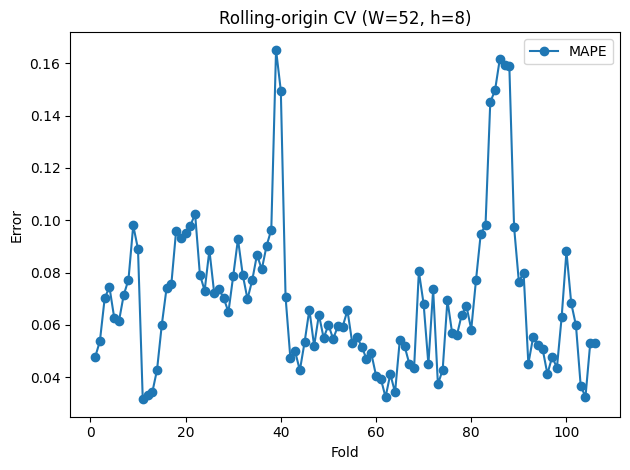

In [65]:
# --- 4. Plot CV metrics ----------------------------------------------------
plt.figure()
plt.plot(cv_df['fold'], cv_df['mape'], marker='o', label='MAPE')
# plt.plot(cv_df['fold'], cv_df['mae'], marker='s', label='MAE')
plt.xlabel("Fold")
plt.ylabel("Error")
plt.title(f"Rolling-origin CV (W={W}, h={H})")
plt.legend()
plt.tight_layout()
plt.show()


Final 8-week hold-out → MAPE: 0.06722684202225501 MSE: 1191136352.672848 MAE: 30757.877062500003


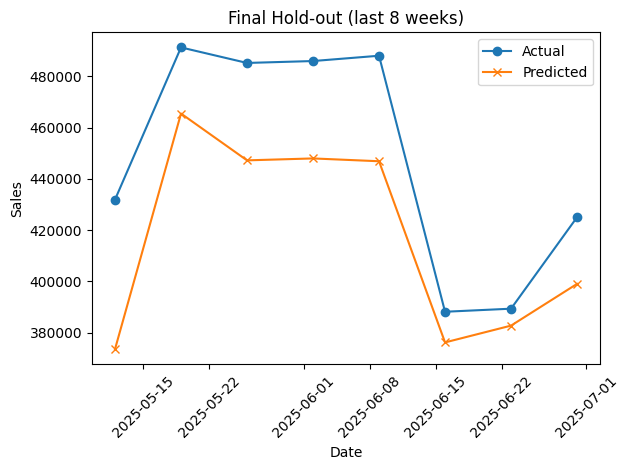

In [75]:
# --- 5. Final hold-out evaluation on last 52 weeks data -----------------------------------------
y_final_pred = final_model.predict(X_final)
print("\nFinal 8-week hold-out →",
      "MAPE:", mean_absolute_percentage_error(y_final, y_final_pred),
      "MSE:", mean_squared_error(y_final, y_final_pred),
      "MAE:", mean_absolute_error(y_final, y_final_pred))

plt.figure()
plt.plot(dates_final, y_final,  marker='o', label='Actual')
plt.plot(dates_final, y_final_pred, marker='x', label='Predicted')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Final Hold-out (last 8 weeks)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [69]:
import os
import joblib

# save model
joblib.dump(final_model, '.marketing_cost/model/marketing_cost_model.joblib')

['model/marketing_cost_model.joblib']

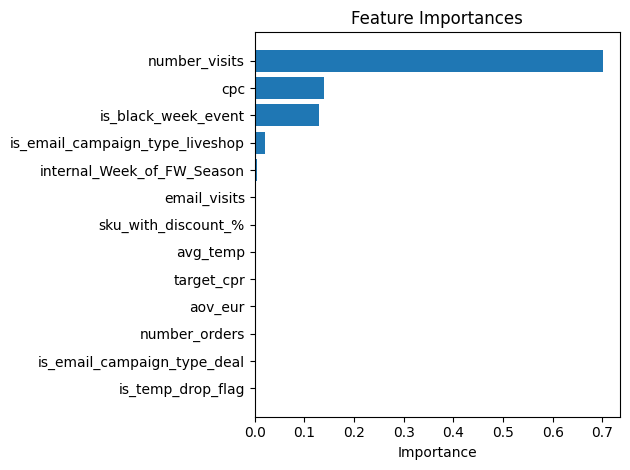

In [73]:
# --- 6. Feature importances -----------------------------------------------
importances = pd.Series(final_model.feature_importances_, index=SELECTED_FEATURES_TO_KEEP)
importances = importances.sort_values(ascending=False)

plt.figure()
plt.barh(importances.index, importances.values)
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()